In [1]:
from tqdm import tqdm
from copy import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font = {'family' : 'Helvetica',
        'size'   : 7}
mpl.rc('font', **font)
from matplotlib import cm
viridis = cm.get_cmap("viridis", 100)

import numpy as np
import cotengra as ctg

from src.circuit import get_random_circuit

/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_33557/494177622.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap("viridis", 100)


# Analytical PDFs

In [2]:
def pdf_top(N, k, t):
    return 2**k * (1-np.exp(-N*t))**(2**k - 1) * N * np.exp(-N*t)

def pdf_q(N, t):
    return N**2 * t * np.exp(-N * t)

def pdf_u(N, t):
    return N * np.exp(-N*t)

def pdf(N, k, phi, t):
    return np.cumsum((1 - np.exp(-N * t / phi))**(2**k - 1) * np.exp(- N * t / phi + N * t / (1 - phi))) * (t[1] - t[0]) * N**2 * np.exp(-N * t / (1 - phi)) * 2**k / phi / (1 - phi)

def R(phi, y1, x2, x3):
    return (y1 - phi * x2 - (1 - phi) * x3) / (2 * np.sqrt(phi * (1 - phi) * x2 * x3))

def f_R(R):
    result = 1 / np.pi / np.sqrt(1 - R ** 2)
    result[np.where(R**2 > 1)] = 0
    return result

# Evidence for the theory of frugal rejection sampling probability distribution.

## Generate random circuit

In [3]:
N = 20
d = 8
quimb_circuit = get_random_circuit(N, d)

## Defining tensor network contraction optimizer

In [4]:
max_repeats = 100
max_time = 20
minimize_target = 'flops'
nslices = 1024

hyperparameters = {
                "methods": ['greedy', 'kahypar'],
                "max_repeats": max_repeats,
                "max_time": max_time,
                "minimize": minimize_target,
                "parallel": 12,
                "progbar": True,
                "slicing_opts": {
                    "allow_outer": False,
                    "target_slices": nslices,
                },
                "optlib": "random",
            }

## Defining tensor network
### The tensor network is for the output state vector.

In [5]:
psi_b = quimb_circuit.get_psi_simplified()
eq = psi_b.get_equation()
operands = []
for tensor in psi_b.tensors:
    operands.append(np.array(tensor.data, dtype = np.complex128))

## Sliced contraction tree

In [6]:
opt = ctg.HyperOptimizer(**hyperparameters)
output_inds = ([psi_b.site_ind(i) for i in range(N)])
tree = psi_b.contraction_tree(output_inds=output_inds, optimize=opt)

F=9.43 C=10.90 S=20.00 P=20.02 $=1024.00: 100%|██████████| 100/100 [00:05<00:00, 18.60it/s]


## Unsliced contraction tree

In [7]:
exact_hyperparameters = copy(hyperparameters)
exact_hyperparameters['slicing_opts'] = {"target_size": 2 ** 28}
exact_opt = ctg.HyperOptimizer(**exact_hyperparameters)
output_inds = ([psi_b.site_ind(i) for i in range(N)])
exact_tree = psi_b.contraction_tree(output_inds=output_inds, optimize=exact_opt)

F=8.42 C=9.56 S=20.00 P=21.00: 100%|██████████| 100/100 [00:02<00:00, 43.76it/s]


## Compute exact state vector

In [8]:
exact_sv = exact_tree.contract(operands)
exact_sv = exact_sv.reshape(-1)
exact_sv = exact_sv / np.sqrt(np.sum(np.abs(exact_sv)**2))

## Frugal rejection sampling

### Skip this if you wish to load precomputed results, just run the cell that calls np.load

### Computing the contribution to the state vector due to each slice, this is to reuse them later to avoid recontracting the same slice.

In [9]:
slice_svs = []
for i in tqdm(range(nslices)):
    sv = tree.contract_slice(operands, i)
    sv = sv.reshape(-1)
    slice_svs.append(sv)
slice_svs = np.array(slice_svs).T

100%|██████████| 1024/1024 [00:11<00:00, 86.11it/s]


### The following performs frugal rejection sampling.

1. Sample $M$ bitstrings
2. Compute the amplitudes of these bitstrings using partial tensor network contraction on a fraction $\phi$ of slices
3. Convert amplitudes to probabilities, normalize, and sample the bitstring out of the $M$ bitstrings weighted by its probability

In [10]:
raise ValueError('This cell takes hours to run. 100k samples is necessary to high quality statistics. Reduce the number of samples to get faster results.')

M = 64
'''Increase samples_per_M to 100k to get good statistics'''
samples_per_M = 100000

all_probs = []
all_frugal_amplitudes = []
all_u_amplitudes = []
phis = np.arange(0.2, 1.001, 0.2)
for phi in phis:
    frugal_amplitudes = []
    u_amplitudes = []
    probs = []
    for _ in tqdm(range(samples_per_M)):
        slices = np.random.choice(a=np.arange(nslices), size=int(nslices * phi), replace=False) # Choose a random subset of slices, a fraction of $\phi$
        bitstrings = np.random.choice(np.arange(2**N), M, replace=False) # Choosing random bitstrings
        slice_amplitudes = slice_svs[bitstrings] # Choose the amplitudes of all slices corresponding to the M random bitstrings
        amplitudes = slice_amplitudes[:, slices] # Choose the amplitudes of the random fraction of slices
        amplitudes = np.sum(amplitudes, axis=1) # Summing over the chosen slices
        amplitudes /= np.sqrt(phi)
        # Compute the weights
        weights = np.abs(amplitudes)**2
        weights /= np.sum(weights)
        # Choose the random bitstring with weight
        idx = np.random.choice(np.arange(M), p=weights)
        bitstring = bitstrings[idx]
        # Record the amplitudes
        frugal_amplitudes.append(amplitudes[idx])
        u_amplitudes.append((exact_sv[bitstring]-np.sqrt(phi)*frugal_amplitudes[-1])/np.sqrt(1-phi))
        prob = np.abs(exact_sv[bitstring]) ** 2
        probs.append(prob)

    all_probs.append(probs)
    all_frugal_amplitudes.append(frugal_amplitudes)
    all_u_amplitudes.append(u_amplitudes)

  0%|          | 0/100000 [00:00<?, ?it/s]/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_49762/4020747830.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  u_amplitudes.append((exact_sv[bitstring]-np.sqrt(phi)*frugal_amplitudes[-1])/np.sqrt(1-phi))
  0%|          | 74/100000 [00:01<27:19, 60.94it/s]/var/folders/04/n445qjrd23s722yrr6_ddmpm0000gp/T/ipykernel_49762/4020747830.py:28: RuntimeWarning: invalid value encountered in scalar divide
  u_amplitudes.append((exact_sv[bitstring]-np.sqrt(phi)*frugal_amplitudes[-1])/np.sqrt(1-phi))
100%|██████████| 100000/100000 [30:03<00:00, 55.44it/s]  


In [ ]:
all_probs = np.array(all_probs)
all_frugal_amplitudes = np.array(all_frugal_amplitudes)
all_u_amplitudes = np.array(all_u_amplitudes)

In [ ]:
np.save('frugal_all_probs.npy', all_probs)
np.save('frugal_all_frugal_amplitudes.npy', all_frugal_amplitudes)
np.save('frugal_all_u_amplitudes.npy', all_u_amplitudes)

In [ ]:
all_probs = np.load('frugal_all_probs')
all_frugal_amplitdues = np.load('frugal_all_frugal_amplitudes')
all_u_amplitudes = np.load('frugal_all_u_amplitudes')

## Supplementary Fig. 12a

In [12]:
hist = np.histogram(np.abs(all_frugal_amplitudes[1]) ** 2 * 2**N, bins=np.linspace(0, 7, 71));

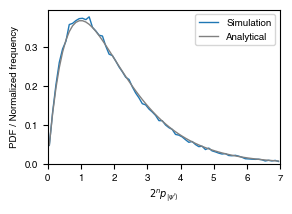

In [13]:
fig, (ax) = plt.subplots(1, 1, figsize=(3, 2))

ps = np.arange(0.05, 7, 0.1)
ax.plot(ps, hist[0] / samples_per_M / 0.1, linewidth=1, label='Simulation')
ax.plot(ps, pdf_q(1, ps), linewidth=1, color='gray', label='Analytical')
ax.set_xlabel(r"$2^n p_{\vert\psi'\rangle}$")
ax.set_ylabel(r'PDF / Normalized frequency')
ax.set_xlim(0, 7)
ax.set_ylim(0,)
plt.legend()
# plt.savefig('frugal_amplitudes.pdf')

## Supplementary Fig. 12b

In [14]:
hist = np.histogram(np.abs(all_u_amplitudes[1]) ** 2 * 2**N, bins=np.linspace(0, 5, 51));

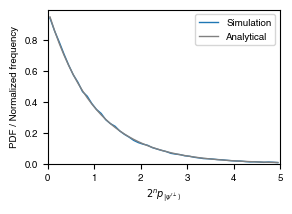

In [15]:
fig, (ax) = plt.subplots(1, 1, figsize=(3, 2))

ps = np.arange(0.05, 5, 0.1)
ax.plot(ps, hist[0] / samples_per_M / 0.1, linewidth=1, label='Simulation')
ax.plot(ps, pdf_u(1, ps), linewidth=1, color='gray', label='Analytical')
ax.set_xlabel(r"$2^n p_{\vert\psi'^{\perp}\rangle}$")
ax.set_ylabel(f'PDF / Normalized frequency')
ax.set_xlim(0, 5)
ax.set_ylim(0,)
plt.legend()
# plt.savefig('frugal_u_amplitudes.pdf')

## Supplementary Fig. 12c

In [16]:
prod = all_frugal_amplitudes[1].reshape(-1) * all_u_amplitudes[1].conj().reshape(-1)
hist = np.histogram(np.real(prod / np.abs(prod)), bins=np.linspace(-1, 1, 201));

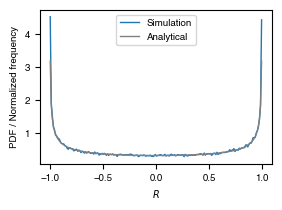

In [17]:
fig, (ax) = plt.subplots(1, 1, figsize=(3, 2))

rs = np.arange(-0.995, 1, 0.01)
ax.plot(rs, hist[0] / samples_per_M / 0.01, linewidth=1, label='Simulation')
ax.plot(rs, f_R(rs), linewidth=1, color='gray', label='Analytical')
ax.set_xlabel(f'$R$')
ax.set_ylabel(f'PDF / Normalized frequency')
plt.legend()
# plt.savefig('frugal_R.pdf')

# Monte-Carlo reproduces the distribution of frugal rejection sampling

### Monte-Carlo samples the probabilities

In [18]:
nsamples = 10000000


x = np.linspace(0, 10, 10001)
r = np.linspace(-0.9999, 0.9999, 19999)
# Use N=1 here since 2**N is only for normalization, improves numerical stability
PDF_Q = pdf_q(2**1, x / 2**1) * (x[1] - x[0]) / 2**1
PDF_Q = PDF_Q / np.sum(PDF_Q)
PDF_U = pdf_u(2**1, x / 2**1) * (x[1] - x[0]) / 2**1
PDF_U = PDF_U / np.sum(PDF_U)
PDF_R = f_R(r) * (r[1] - r[0])
PDF_R = PDF_R / np.sum(PDF_R)
u_samples = np.random.choice(x, size=nsamples, p=PDF_U)
r_samples = np.random.choice(r, size=nsamples, p=PDF_R)


hists = []

phis = np.arange(0.2, 1.05, 0.2)
means = []

for phi in phis:
    q_samples = np.random.choice(x, size=nsamples, p=PDF_Q)
    result = phi * q_samples + (1 - phi) * u_samples + 2 * np.sqrt(phi * (1 - phi)) * r_samples * np.sqrt(q_samples * u_samples)
    means.append(np.mean(result)-1)
    hists.append(np.histogram(result, bins=np.linspace(0,7,71)));

## Supplementary Fig. 11b

(0.0, 0.8117748514880996)

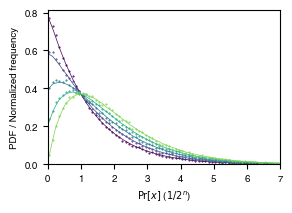

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(3, 2))

bin_centers = np.linspace(0.05, 6.95, 70)

for i, phi in enumerate(phis):
    probs = all_probs[i]
    actual_hist = np.histogram(probs, bins=np.linspace(0, 7, 71)/2**N)
    actual_freq = actual_hist[0] / (np.sum(actual_hist[0]) * (bin_centers[1] - bin_centers[0]))
    rescaled_freq = hists[i][0] / (np.sum(hists[i][0]) * (bin_centers[1] - bin_centers[0]))
    honest_density = phi * pdf_q(1, bin_centers) + (1 - phi) * pdf_u(1, bin_centers)

    axs.plot(bin_centers, rescaled_freq, '-', color=viridis(i/5), markersize=1, linewidth=0.5, label='Monte-Carlo')
    axs.plot(bin_centers, actual_freq, '.', color=viridis(i/5), markersize=1, linewidth=0.5, label='Experiment')
axs.set_xlabel(f'$\Pr[x]$ ($1/2^n$)')
axs.set_ylabel(f'PDF / Normalized frequency')
axs.set_xlim(0, 7)
axs.set_ylim(0, )
# plt.savefig('frugal_monte_carlo_vs_experiment.pdf')

## Supplementary Fig. 11a

(0.0, 0.8117723972070897)

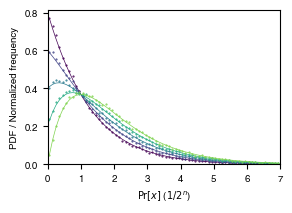

In [20]:
fig, axs = plt.subplots(1, 1, figsize=(3, 2))

bin_centers = np.linspace(0.05, 6.95, 70)

for i, phi in enumerate(phis):
    probs = all_probs[i]
    actual_hist = np.histogram(probs, bins=np.linspace(0, 7, 71)/2**N)
    actual_freq = actual_hist[0] / (np.sum(actual_hist[0]) * (bin_centers[1] - bin_centers[0]))
    rescaled_freq = hists[i][0] / (np.sum(hists[i][0]) * (bin_centers[1] - bin_centers[0]))
    honest_density = phi * pdf_q(1, bin_centers) + (1 - phi) * pdf_u(1, bin_centers)

    axs.plot(bin_centers, honest_density, '-', color=viridis(i/5), linewidth=0.5, label=f'{phi}')
    axs.plot(bin_centers, actual_freq, '.', color=viridis(i/5), markersize=1, linewidth=0.5, label=f'{phi}')
    
axs.set_xlabel(f'$\Pr[x]$ ($1/2^n$)')
axs.set_ylabel(f'PDF / Normalized frequency')
axs.set_xlim(0, 7)
axs.set_ylim(0, )
# plt.savefig('frugal_honest_vs_experiment.pdf')